In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/AutoEncoder_for_images/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')
path = 'lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    print("CUDA not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


torch.Size([250, 250, 3])


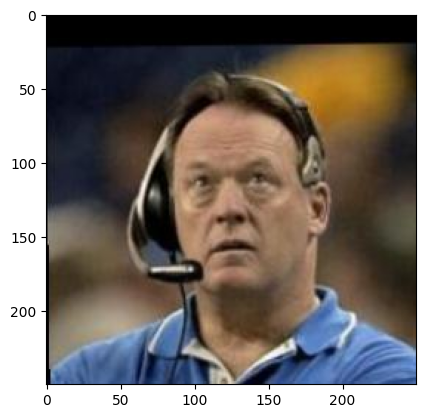

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

AutoEncoders (AEs) and Variational AutoEncoders (VAEs) are both types of neural network architectures used for unsupervised learning, typically in the context of dimensionality reduction or generative tasks. While they share some similarities, there are significant differences in their applications, architectures, and loss functions.



---


**Applications**

---



**AutoEncoders:**

Primarily used for dimensionality reduction, feature learning, and denoising.
Often employed in scenarios where compressed representations of data are needed, such as data visualization or preprocessing for other machine learning tasks.

**Variational AutoEncoders:**

Used for generative tasks, in addition to dimensionality reduction.
Commonly applied in image generation, text generation, and other fields where generating new samples that resemble the training data is desirable.
Suitable for semi-supervised learning tasks due to their probabilistic nature.


---


**Architecture**


---


**AutoEncoders:**

Consist of an encoder and a decoder. The encoder compresses the input into a lower-dimensional latent space, and the decoder reconstructs the output from this latent representation.
The latent space is deterministic, meaning each input directly maps to a specific point in the latent space.

**Variational AutoEncoders:**

Also consist of an encoder and a decoder, but the latent space is probabilistic.
The encoder in a VAE outputs parameters (mean and variance) of a probability distribution representing the data in the latent space.
Incorporates a reparameterization trick for differentiability: samples a random vector from the distribution and passes it through the decoder to generate output.


---


**Loss Function**


---


**AutoEncoders:**

The loss function typically measures the difference between the input and its reconstruction, often using Mean Squared Error (MSE) or Binary Cross Entropy (BCE).
The goal is to minimize the reconstruction error.

**Variational AutoEncoders:**

The loss function in VAEs is composed of two terms: a reconstruction loss (like in AEs) and a regularization term.
The reconstruction loss measures how effectively the decoder reconstructs the input.
The regularization term, often the Kullback-Leibler (KL) divergence, ensures the distribution of the latent space resembles a prior distribution (usually a standard normal distribution). This term is crucial for learning a well-formed latent space and enabling generative properties.
The balance between these two terms controls the trade-off between reconstruction fidelity and the smoothness/density of the latent space.

In summary, while AEs focus on learning efficient encodings of data, VAEs extend this concept to generative modeling by introducing a probabilistic latent space and a more complex loss function that balances reconstruction quality with latent space regularization.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [8]:
import torch.nn.functional as F

# VAE class created by making changes to autoencoder architecture

class VAE(nn.Module):
    def __init__(self, latent_dims=20):
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64 * 32 * 32, latent_dims)
        self.fc_logvar = nn.Linear(64 * 32 * 32, latent_dims)

        # Decoder layers
        self.decoder_input = nn.Linear(latent_dims, 64 * 32 * 32)

        # Adjusting the decoder to output an image of size [3, 250, 250]
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),  # Output: [64, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=1),  # Output: [32, 128, 128]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),  # Output: [16, 256, 256]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=1, padding=0),   # Output: [3, 250, 250]
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar) # the mean of the latent space
        eps = torch.randn_like(std) # log variance of the latent space
        return mu + eps*std

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(h1.size(0), -1)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(h3.size(0), 64, 32, 32)
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [15]:
# Instantiate the VAE model
model = VAE().to(device)

# Load one batch of images
images, _ = next(iter(dataloader))
images = images.to(device)

# Forward pass through the model to check if it is working properly
decoded, mu, logvar = model(images)

# Reparameterize to get latent space samples from the output of encoder
std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
z = mu + eps * std

# Print the shapes
print("Shape of mu:", mu.shape)
print("Shape of logvar:", logvar.shape)
print("Shape of latent space samples (z):", z.shape)
print("Shape of decoded images:", decoded.shape)

Shape of mu: torch.Size([32, 20])
Shape of logvar: torch.Size([32, 20])
Shape of latent space samples (z): torch.Size([32, 20])
Shape of decoded images: torch.Size([32, 3, 250, 250])


## Generating New Samples in the Latent Space of a VAE

The VAE's encoder produces two outputs for each input image: mu (the mean of the latent space distribution) and log_var (the log variance of the latent space distribution). These outputs parameterize a Gaussian distribution in the latent space from which we can sample.

To generate new samples, we use the reparameterization trick. This involves sampling an epsilon (eps) from a standard normal distribution and then transforming this sample using the mu and log_var from the encoder. Specifically, the sample z is computed as mu + exp(0.5 * log_var) * eps. This approach allows the model to backpropagate through the stochastic sampling process, which is crucial for training VAEs.

By sampling different eps values, we can generate various points in the latent space, which, when passed through the decoder, yield different output images.

### Understanding the Latent Space
In a VAE, the encoder transforms input data (like images) into a probabilistic latent space. This space is characterized by probability distributions for each data point, typically Gaussian distributions. Each distribution is described by a mean (μ) and a variance (σ²).

### The Reparameterization Trick
To generate a new sample:
1. **Sample `ε` from a standard normal distribution**: This value is a random sample with a mean of 0 and a variance of 1.
2. **Transform `ε` using the mean and variance from the encoder**: The formula used is `z = μ + ε * σ`. This step adapts the standard normal sample according to our specific distribution.

This "reparameterization trick" allows the model to backpropagate gradients because `μ` and `σ` are deterministic and differentiable.

### Generating New Images
Once we have our sampled latent vector `z`, we pass it through the decoder, which reconstructs data resembling the original input:
1. **Input `z` to the decoder**: The decoder processes `z`.
2. **Decoder output**: It outputs data (e.g., an image) that mimics the original data distribution. The shape of this output matches the original input shape.

In summary, the VAE's latent space is like a library of book descriptions (distributions) rather than exact books (data points). To create a new book (data), we can imagine one based on a description (sample from the distribution) and then write (decode) it to see what it looks like. This allows the VAE to generate new, similar data based on learned patterns.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [16]:
# Calculate the total number of parameters in the VAE model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the total number of parameters
print(f'The model has {total_params:,} trainable parameters.')

The model has 4,071,867 trainable parameters.


In [11]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In the initial phase of my Variational AutoEncoder (VAE), I employed the Mean Squared Error (MSE) as the reconstruction loss function. MSE, calculated as the average squared difference between the reconstructed and original images, is a common choice for models dealing with continuous input data values. It effectively measures the variance between the predicted and actual values, making it suitable for many regression problems.

However, during the training process, I encountered a significant challenge: gradient exploding. This phenomenon, where gradients become excessively large and cause unstable training behavior, was particularly evident in my VAE model. The use of MSE in the context of my VAE's architecture and data seemed to exacerbate this issue, leading to numerical instability and hindering the model's learning process.

To address this, I shifted from MSE to Binary Cross Entropy (BCE) as the reconstruction loss function. BCE measures the difference between two probability distributions - the actual label and the predicted label - making it more suitable for models that output probabilities, which was the case in my VAE project. This loss function calculates the cross-entropy loss for binary classification tasks, effectively capturing the dissimilarity in the probabilistic distribution of the reconstructed and original data.

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

When working with Variational AutoEncoders (VAEs), we use a special kind of loss function that's different from other models. This loss function has two main parts, and each plays a crucial role in how the VAE learns and performs.

### 1. Reconstruction Loss: Being a Good Copycat
- **Purpose**: The first part of the loss function is about how well the VAE can recreate or reconstruct the input data it's given.
- **Why It's Important**: This is crucial because we want our VAE not just to store the data but to understand and reproduce it effectively. It's like teaching someone to paint by having them replicate famous paintings; they learn by imitating.
- **In VAEs**: The VAE learns to compress data into a compact form (in the latent space) and then reconstruct it back. The better it can do this, the more accurately it understands the data.

### 2. KL Divergence: Learning to Imagine
- **Purpose**: The second part, called KL Divergence, is a bit more abstract. It measures how the data representations (or ideas) created by the VAE match up to a certain standard pattern.
- **Why It's Important**: This ensures that the VAE's representations are not just random but follow a predictable, organized structure. It's like teaching someone to not only copy a painting but also to create their own paintings that still make sense artistically.
- **In VAEs**: By keeping the VAE's ideas in line with this standard pattern, we enable the model to generate new data that's both diverse and realistic. It's essential for making sure the VAE can not only mimic(replicate) but also innovate something new.

### The Balance: Copying and Creating
- **The Combination**: These two parts together make the VAE's loss function unique. While the Reconstruction Loss ensures the VAE is a great copier, the KL Divergence makes sure it's also a creative artist.
- **Overall Goal**: The aim is to have a model that can both accurately reproduce its input data and generate new, realistic data that's similar to but not exactly the same as the input. It's like training an artist who can both replicate existing art and create new, original works.

In simple terms, the loss function for VAEs is designed to ensure that the model can understand, replicate, and creatively expand upon the data it's given. It's not just about memorizing; it's about understanding and innovating, which is what makes VAEs so powerful in the world of generative models.


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [12]:
# Number of epochs
num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Average loss for this epoch
    epoch_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}")

Epoch [1/50], Loss: 104235.33694379391
Epoch [2/50], Loss: 98715.15817405756
Epoch [3/50], Loss: 98209.38940092166
Epoch [4/50], Loss: 97906.32016317897
Epoch [5/50], Loss: 97711.48353101156
Epoch [6/50], Loss: 97544.51025534487
Epoch [7/50], Loss: 97412.89653055828
Epoch [8/50], Loss: 97279.24579776384
Epoch [9/50], Loss: 97167.56103157815
Epoch [10/50], Loss: 97075.45929969026
Epoch [11/50], Loss: 96994.17334932387
Epoch [12/50], Loss: 96912.93063949536
Epoch [13/50], Loss: 96844.58152338144
Epoch [14/50], Loss: 96758.88515146937
Epoch [15/50], Loss: 96696.11629334441
Epoch [16/50], Loss: 96636.06197590088
Epoch [17/50], Loss: 96575.96116944928
Epoch [18/50], Loss: 96499.40401903755
Epoch [19/50], Loss: 96437.66815554885
Epoch [20/50], Loss: 96336.83895520133
Epoch [21/50], Loss: 96216.14956183426
Epoch [22/50], Loss: 96080.39898579738
Epoch [23/50], Loss: 95952.3186900355
Epoch [24/50], Loss: 95897.18560663292
Epoch [25/50], Loss: 95821.55668769359
Epoch [26/50], Loss: 95769.1586178

## Following Steps can be taken to Ensure Continuous Decreasing Loss in VAE Training.


1. **Fine-Tuned the Learning Rate**: we can adjust the learning rate because if it's too high, the model might miss the optimal solution, and if it's too low, it'll take too long to converge. Finding the right balance is the key.

2. **Verify the Loss Function**: Since VAEs have a unique loss function, combining reconstruction loss and KL divergence, I double-checked to ensure it was implemented correctly. It's crucial because this loss function guides the model to learn both data representation and generation.

3. **Tuned the Model Architecture**: we can revisit VAE's architecture, changing the layer sizes and structures, ensuring it was well-suited can help significantly.


Through these steps, we would be able to see a consistent decrease in the loss, indicating that the model was learning effectively and improving over time.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

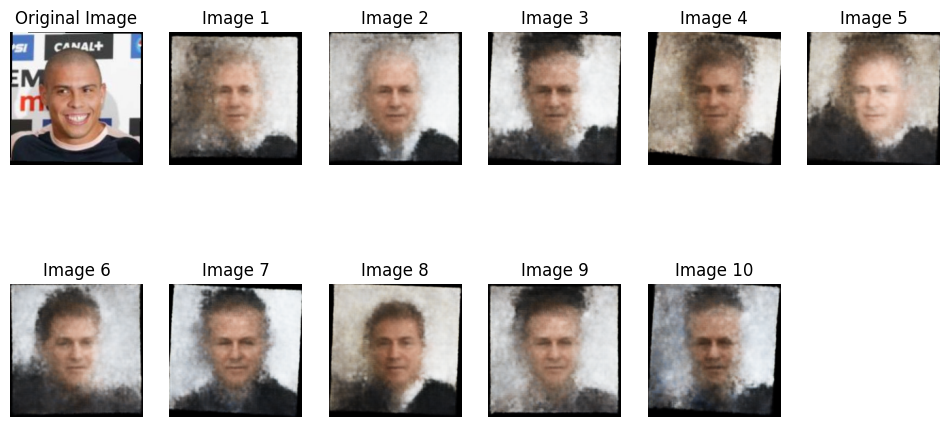

In [13]:
model.eval()

# Select a random image from the dataset
with torch.no_grad():
    data, _ = next(iter(dataloader))
    random_index = random.randint(0, data.size(0) - 1)
    original_image = data[random_index].unsqueeze(0).to(device)  # Add batch dimension

    # Encoding the image to get the latent space representation
    mu, logvar = model.encode(original_image)

    # Reparameterize to sample from the latent space
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(mu)
    z = mu + eps * std

    # Plotting the original image
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 6, 1)
    plt.imshow(original_image.cpu().squeeze().permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    # Generating and plottting 10 similar images with amplified variations
    for i in range(2, 12):
        # Introducing amplified variation
        z_varied = z + torch.randn_like(z) * 0.5

        # Decoding the latent vector
        generated_image_varied = model.decode(z_varied)

        # Plotting the generated images
        plt.subplot(2, 6, i)
        plt.imshow(generated_image_varied.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"Image {i-1}")
        plt.axis('off')

    plt.show()

In [ ]:
# Other Architectures implemented by me for Variational Autoencoders are given in next cells.

class VAE1(nn.Module):
    def __init__(self, latent_dims=20):
        super(VAE1, self).__init__()

        # Define the layers for the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # b, 64, 250, 250
            nn.BatchNorm2d(64),  # b, 64, 250, 250
            nn.ReLU(True),  # b, 64, 250, 250
            nn.MaxPool2d(2, stride=2),  # b, 64, 125, 125
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # b, 128, 125, 125
            nn.BatchNorm2d(128),  # b, 128, 125, 125
            nn.ReLU(True),  # b, 128, 125, 125
            nn.MaxPool2d(2, stride=2),  # b, 128, 62, 62
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=2),  # b, 128, 64, 64
            nn.BatchNorm2d(128),  # b, 128, 64, 64
            nn.ReLU(True),  # b, 128, 64, 64
            nn.MaxPool2d(2, stride=2)  # b, 128, 32, 32
        )

        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dims)
        self.fc_logvar = nn.Linear(128 * 32 * 32, latent_dims)

        # Define the layers for the decoder
        self.decoder_input = nn.Linear(latent_dims, 128 * 32 * 32)

        # Adjust the decoder to output an image of size [3, 250, 250]
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def encode(self, x):
        encoded = self.encoder(x)
        h1 = encoded.view(encoded.size(0), -1)
        return encoded, self.fc_mu(h1), self.fc_logvar(h1)

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(h3.size(0), 128, 32, 32)  # Reshape to match the input shape of the decoder
        return self.decoder(h3)

    def forward(self, x):
        encoded, mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return encoded, self.decode(z), mu, logvar

In [ ]:
class VAE2(nn.Module):
    def __init__(self, latent_dims=20):
        super(VAE2, self).__init__()

        # Define the layers for the encoder
        self.encoder = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # b, 64, 250, 250
                                 nn.BatchNorm2d(32),  # b, 64, 250, 250
                                 nn.ReLU(True),  # b, 64, 250, 250
                                 nn.MaxPool2d(2, stride=2),  # b, 64, 125, 125

                                 nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # b, 128, 125, 125
                                 nn.BatchNorm2d(64),  # b, 128, 125, 125
                                 nn.ReLU(True),  # b, 128, 125, 125
                                 nn.MaxPool2d(2, stride=2),  # b, 128, 62,

                                 nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),  # b, 128, 64, 64
                                 nn.BatchNorm2d(128),  # b, 128, 64, 64
                                 nn.ReLU(True),  # b, 128, 64, 64
                                 nn.MaxPool2d(2, stride=2) # b, 128, 32, 32
                                )

        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dims)
        self.fc_logvar = nn.Linear(128 * 32 * 32, latent_dims)

        # Define the layers for the decoder
        self.decoder_input = nn.Linear(latent_dims, 128 * 32 * 32)

        # Adjust the decoder to output an image of size [3, 250, 250]
        self.decoder = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(64),

                             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(32),

                             nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                             nn.Tanh()
                            )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def encode(self, x):
        encoded = self.encoder(x)
        h1 = encoded.view(encoded.size(0), -1)
        return encoded, self.fc_mu(h1), self.fc_logvar(h1)

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(h3.size(0), 128, 32, 32)  # Reshape to match the input shape of the decoder
        return self.decoder(h3)

    def forward(self, x):
        encoded, mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return encoded, self.decode(z), mu, logvar

In [ ]:
class VAE3(nn.Module):
    def __init__(self, latent_dims=20):
        super(VAE3, self).__init__()

        # Define the layers for the encoder
        self.encoder = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # b, 64, 250, 250
                                 nn.BatchNorm2d(32),  # b, 64, 250, 250
                                 nn.ReLU(True),  # b, 64, 250, 250
                                 nn.MaxPool2d(2, stride=2),  # b, 64, 125, 125

                                 nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # b, 128, 125, 125
                                 nn.BatchNorm2d(64),  # b, 128, 125, 125
                                 nn.ReLU(True),  # b, 128, 125, 125
                                 nn.MaxPool2d(2, stride=2),  # b, 128, 62,

                                 nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),  # b, 128, 64, 64
                                 nn.BatchNorm2d(128),  # b, 128, 64, 64
                                 nn.ReLU(True),  # b, 128, 64, 64
                                 nn.MaxPool2d(2, stride=2), # b, 128, 32, 32

                                 nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # b, 256, 32, 32
                                 nn.BatchNorm2d(128),  # b, 256, 32, 32
                                 nn.ReLU(True),  # b, 256, 32, 32
                                 nn.MaxPool2d(2, stride=2) # b, 256, 16, 16
                                )

        self.fc_mu = nn.Linear(256 * 16 * 16, latent_dims)
        self.fc_logvar = nn.Linear(256 * 16 * 16, latent_dims)

        # Define the layers for the decoder
        self.decoder_input = nn.Linear(latent_dims, 256 * 16 * 16)

        # Adjust the decoder to output an image of size [3, 250, 250]
        self.decoder = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1), #b, 128, 31, 31
                             nn.BatchNorm2d(64), #b, 128, 31, 31

                             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), #b, 64, 62, 62
                             nn.BatchNorm2d(32), #b, 64, 62, 62

                             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), #b, 32, 124, 124
                             nn.BatchNorm2d(16), #b, 32, 124, 124

                             nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, output_padding=1), #b, 3, 250, 250
                             nn.Tanh()
                            )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def encode(self, x):
        encoded = self.encoder(x)
        h1 = encoded.view(encoded.size(0), -1)
        return encoded, self.fc_mu(h1), self.fc_logvar(h1)

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(h3.size(0), 256, 16, 16)  # Reshape to match the input shape of the decoder
        return self.decoder(h3)

    def forward(self, x):
        encoded, mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return encoded, self.decode(z), mu, logvar